Notebook to generate data file that is a subset of the SGA catalog with rotational velocities measured during EDR (fuji).

In [1]:
import numpy as np

from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
c = const.c.to_value('km/s')

q0 = 0.2

# Redrock systematic duplicate redshift uncertainty (from Lan+23)
dv_sys = 7 # km/s
dz_sys = dv_sys/c
#### Ultimately dz = (1+z) dv/c, but we will multiply this by (1+z) for each observation

# Data

## fuji

In [4]:
# tfuji = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
tfuji = Table.read('/Users/kdouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


### Update all Redrock uncertainties to account for 7 km/s statistical uncertainty

In [5]:
tfuji['ZERR_MOD'] = np.sqrt(tfuji['ZERR']**2 + (dz_sys*(1 + tfuji['Z']))**2)

### Are $\sigma_z$ small relative to $z$?

In [6]:
np.max(tfuji['ZERR_MOD']/tfuji['Z'])

np.float64(18.759445789772432)

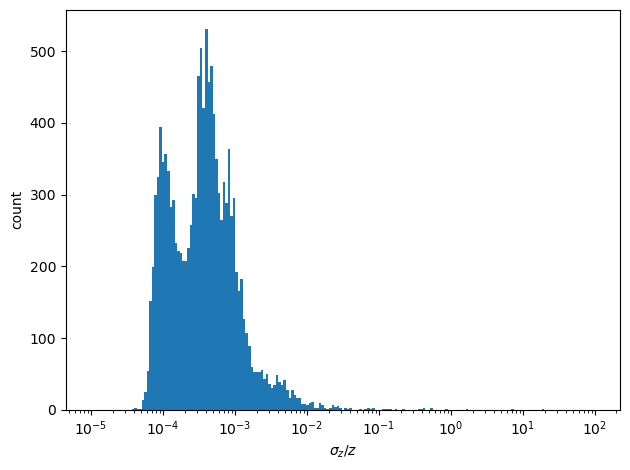

In [7]:
plt.figure(tight_layout=True)

plt.hist(tfuji['ZERR_MOD']/tfuji['Z'], bins=np.logspace(-5, 2, 200))

plt.xscale('log')

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

## SGA

In [8]:
# SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [9]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

# Separate the fuji data into center and off-center observations

In [10]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in tqdm(np.unique(tfuji['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

100%|███████████████████████████████████████████████████████████████████████| 4524/4524 [00:01<00:00, 2340.94it/s]


In [11]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

## Clean the fuji center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0
* passed VI

In [12]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]
print(len(np.unique(good_centers['SGA_ID'])), len(good_centers))

4255 4434


In [15]:
fuji_VI = Table.read('fuji_VI.txt', format='ascii.commented_header')

centers_VI = np.ones(len(good_centers), dtype=bool)

for targetid in fuji_VI['TARGETID']:

    if targetid in good_centers['TARGETID']:
        centers_VI = centers_VI & (good_centers['TARGETID'] != targetid)

good_centers_VI = good_centers[centers_VI]
print(len(np.unique(good_centers_VI['SGA_ID'])), len(good_centers_VI))

4255 4434


### How does $\sigma_z$ compare with $z$ for the good center observations?

In [16]:
print(np.max(good_centers_VI['ZERR_MOD']/good_centers_VI['Z']), np.max(fuji_axis['ZERR_MOD']/fuji_axis['Z']))

0.5409363125316831 18.759445789772432


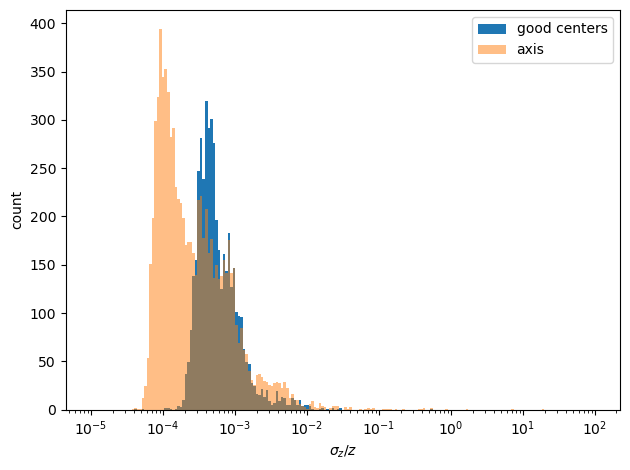

In [17]:
plt.figure(tight_layout=True)

plt.hist(good_centers_VI['ZERR_MOD']/good_centers_VI['Z'], bins=np.logspace(-5, 2, 200), label='good centers')
plt.hist(fuji_axis['ZERR_MOD']/fuji_axis['Z'], bins=np.logspace(-5, 2, 200), alpha=0.5, label='axis')

plt.xscale('log')

plt.legend()

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

### Are there any galaxies with multiple good center observations?

In [18]:
unique_ids, counts = np.unique(good_centers_VI['SGA_ID'], return_counts=True)

print(unique_ids[counts > 1], counts[counts > 1])

 SGA_ID
-------
    848
   3727
   6443
  10959
  12318
  16649
  26199
  28451
  37543
  46327
    ...
1364394
1365198
1366241
1374698
1380792
1382772
1386484
1392414
1401610
1418640
Length = 175 rows [2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [19]:
rng = np.random.default_rng()

N_samples = 10000 # for large error propagation

In [20]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

# weights = 1./(good_centers_VI['ZERR']**2)
weights = 1./(good_centers_VI['ZERR_MOD']**2)

for sga_id in tqdm(np.unique(good_centers_VI['SGA_ID'])):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers_VI['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers_VI['Z'][obs_idx], 
                                        weights=weights[obs_idx])

    # Compute the uncertainty in the center redshfit
    # if N_obs == 1 or np.all(np.abs(good_centers['ZERR_MOD'][obs_idx]/good_centers['Z'][obs_idx]) < 0.05):
    #     SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./(N_obs*np.sum(weights[obs_idx])))
    # else:
    z_random = np.zeros((N_obs, N_samples))

    for i in range(N_obs):
        z_random[i] = rng.normal(scale=good_centers_VI['ZERR_MOD'][obs_idx][i], 
                                 loc=good_centers_VI['Z'][obs_idx][i], 
                                 size=N_samples)
    
    avg_z_random = np.average(z_random, 
                              weights=weights[obs_idx,None]*np.ones(N_samples), 
                              axis=0)
    SGA['ZERR_DESI'][SGA_idx] = np.std(avg_z_random)

100%|███████████████████████████████████████████████████████████████████████| 4255/4255 [00:00<00:00, 5417.18it/s]


In [21]:
print(good_centers_VI['Z', 'ZERR', 'ZERR_MOD'][good_centers_VI['SGA_ID'] == 848])
print(SGA['Z_DESI', 'ZERR_DESI'][SGA['SGA_ID'] == 848])

        Z                  ZERR                ZERR_MOD       
------------------ -------------------- ----------------------
0.0699433547367303 9.06362424382781e-06  2.657594760008733e-05
0.0699116031710255 2.72330650976674e-05 3.6955845250693285e-05
       Z_DESI             ZERR_DESI       
------------------- ----------------------
0.06993253168670704 2.1717980476109552e-05


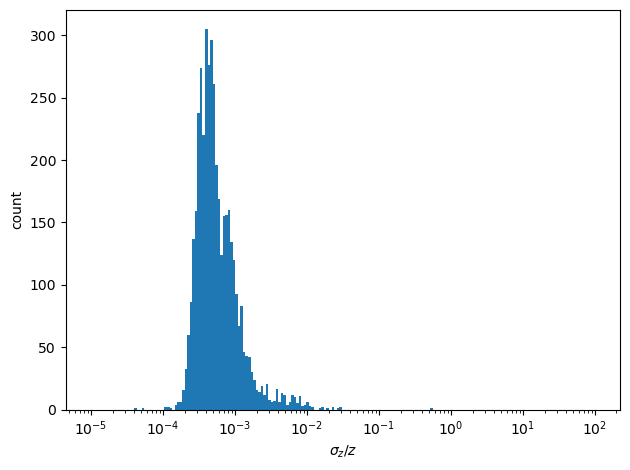

In [22]:
plt.figure(tight_layout=True)

plt.hist(SGA['ZERR_DESI']/SGA['Z_DESI'], bins=np.logspace(-5, 2, 200))

plt.xscale('log')

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

# Calculate the rotational velocity

In [23]:
fuji_axis['V_ROT'] = np.nan
fuji_axis['V_ROT_ERR'] = np.nan

# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in tqdm(np.unique(good_centers_VI['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = fuji_axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]

    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = SGA['Z_DESI'][sga_idx]
    z_err_center = SGA['ZERR_DESI'][sga_idx]

    # Calculate rotational velocity for all observations of the galaxy
    # fuji_axis['V_ROT'][obs_idx] = c.to('km/s')*(fuji_axis['Z'][obs_idx] - z_center)
    z_rot = (1 + fuji_axis['Z'][obs_idx])/(1 + z_center) - 1
    fuji_axis['V_ROT'][obs_idx] = c*z_rot

    # Calculate uncertainty in the rotational velocity
    # if np.all(np.abs(fuji_axis['ZERR_MOD'][obs_idx]/fuji_axis['Z'][obs_idx]) < 0.05) and (z_err_center/z_center < 0.05):
    #     # fuji_axis['V_ROT_ERR'][obs_idx] = c.to('km/s')*np.sqrt(fuji_axis['ZERR'][obs_idx]**2 + z_err_center**2 + (dv_sys/c.to('km/s')).value**2)
    #     fuji_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((fuji_axis['ZERR_MOD'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + fuji_axis['Z'][obs_idx])/(1 + z_center)**2))
    #     # fuji_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis_inComa['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + fuji_axis['Z'][obs_idx])/(1 + z_center)**2) + (dv_sys/c).value**2)
    # else:
    z_center_random = rng.normal(scale=z_err_center, 
                                 loc=z_center, 
                                 size=N_samples)

    z_axis_random = np.zeros((np.sum(obs_idx), N_samples))

    for i in range(np.sum(obs_idx)):
        z_axis_random[i] = rng.normal(scale=fuji_axis['ZERR_MOD'][obs_idx][i], 
                                      loc=fuji_axis['Z'][obs_idx][i], 
                                      size=N_samples)

    z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1

    fuji_axis['V_ROT_ERR'][obs_idx] = np.std(np.abs(c*z_rot_random), axis=1)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    fuji_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    fuji_axis['V_ROT_ERR'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

100%|███████████████████████████████████████████████████████████████████████| 4255/4255 [00:01<00:00, 3456.70it/s]


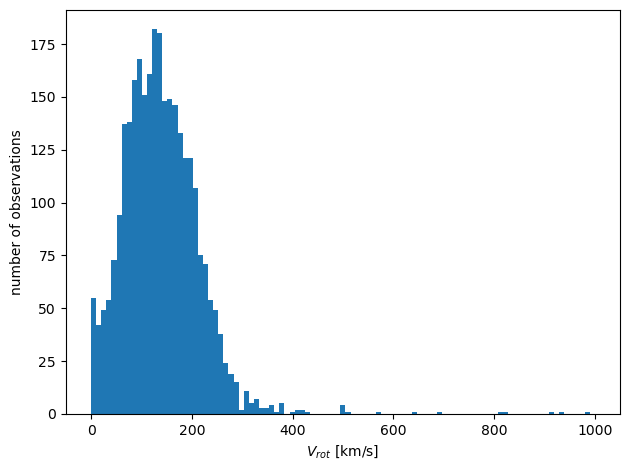

In [24]:
plt.figure(tight_layout=True)

plt.hist(np.abs(fuji_axis['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Quality criteria for velocities

Requirements:
* $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
* $\Delta V / V_{min} \leq 5$
* Velocity sign consistency
* passes VI

## Velocity cut

In [25]:
r0p3 = (fuji_axis['SKY_FIBER_DIST_R26'] > 0.3) & (fuji_axis['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(fuji_axis['V_ROT']) < 1000) & (np.abs(fuji_axis['V_ROT']) > 10)

good_axis = fuji_axis[r0p3 & Vgood]

print(len(good_axis), len(np.unique(good_axis['SGA_ID'])))

2333 1204


## Visual inspection

Cutouts for this were generated with the `TF_SV_VI.ipynb` notebook.

In [26]:
axis_VI = np.ones(len(good_axis), dtype=bool)

for targetid in fuji_VI['TARGETID']:

    if targetid in good_axis['TARGETID']:
        axis_VI = axis_VI & (good_axis['TARGETID'] != targetid)

good_axis_VI = good_axis[axis_VI]
print(len(good_axis_VI), len(np.unique(good_axis_VI['SGA_ID'])))

2319 1199


## Relative velocity cut

In [27]:
good_deltaV = np.ones(len(good_axis_VI), dtype=bool)

deltachi2_idx = good_axis_VI['DELTACHI2'] >= 25

for sga_id in tqdm(np.unique(good_axis_VI['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_VI['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_VI['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_VI['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_VI['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_VI['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_VI['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_VI['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_VI['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_VI['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_VI['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

100%|███████████████████████████████████████████████████████████████████████| 1199/1199 [00:00<00:00, 8125.07it/s]


In [28]:
good_deltaV_axis = good_axis_VI[good_deltaV]

print(len(good_deltaV_axis), len(np.unique(good_deltaV_axis['SGA_ID'])))

2299 1192


## Same side check

Confirm that all velocities measured on the same side of the galaxy have the same sign (either positive or negative), and that velocities measured on opposite sides have the opposite sign.  If one of these cases fails, remove observations with `DELTACHI2` < 25 and recheck.  If it still fails, remove all observations on that side of the galaxy, or that galaxy.

In [29]:
def check_sides(galaxy):
    '''
    Check that the rotational velocities have the same sign on each side of the 
    galaxy.
    '''
    # Find which observations are on the same, opposite side
    same_side = (galaxy['TARGET_RA'] == galaxy['TARGET_RA'][0]) & (galaxy['TARGET_DEC'] == galaxy['TARGET_DEC'][0])

    # Check that all velocities on the same side as the first in the table have 
    # the same sign
    same1 = galaxy['V_ROT'][same_side] > 0
    check_same = np.all(same1 == same1[0])

    # Check if there are observations on the opposite side of the galaxy from 
    # the first one in the table
    if np.sum(same_side) < len(galaxy):

        # Check that all the velocities on this side have the same sign
        same2 = galaxy['V_ROT'][~same_side] > 0
        check_same2 = np.all(same2 == same2[0])

        # Check that the signs are opposite each other on the two sides
        check_opposite = check_same & check_same2 & (same1[0] != same2[0])

        # Combine all the checks into one boolean value
        check_same = check_same & check_same2 & check_opposite

    return check_same

In [31]:
same_side_good = np.ones(len(good_deltaV_axis), dtype=bool)

deltachi2_idx = good_deltaV_axis['DELTACHI2'] >= 25


for sga_id in tqdm(np.unique(good_deltaV_axis['SGA_ID'])):

    # Identify all observations on this galaxy
    obs_idx = good_deltaV_axis['SGA_ID'] == sga_id

    n_obs = np.sum(obs_idx)

    if n_obs > 1:

        # Make a small table of just this galaxy
        this_gal = good_deltaV_axis[obs_idx]

        # deltachi2_this_gal = this_gal['DELTACHI2'] >= 25

        # Check the observations
        check_same = check_sides(this_gal)

        if ~check_same:
            # At least one of the observations is the wrong sign

            # First, just remove all with DELTACHI2 < 25
            same_side_good[obs_idx & ~deltachi2_idx] = False

            # Which observations are left?
            good_obs_idx = obs_idx & deltachi2_idx

            # How many observations are left?
            n_obs_good = np.sum(good_obs_idx)

            if n_obs_good > 1:

                # Recheck those that are left to see if they pass
                check_same_again = check_sides(good_deltaV_axis[good_obs_idx])

                # If this still fails, remove all observations on this galaxy
                if ~check_same_again:
                    same_side_good[obs_idx] = False

100%|███████████████████████████████████████████████████████████████████████| 1192/1192 [00:00<00:00, 5958.45it/s]


In [32]:
good_deltaV_axis_same = good_deltaV_axis[same_side_good]

print(len(good_deltaV_axis_same), len(np.unique(good_deltaV_axis_same['SGA_ID'])))

2286 1188


# Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$

In [34]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_ERR'] = np.nan

weights = 1./(good_deltaV_axis_same['V_ROT_ERR']**2)

for sga_id in np.unique(good_deltaV_axis_same['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_deltaV_axis_same['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)

    if N_obs > 1:

        # Make a small table of just this galaxy
        this_gal = good_deltaV_axis_same[obs_idx]

        weights_z = 1./(this_gal['ZERR_MOD']**2)

        # Observations that are on the same side as the first one in this list
        same_side = (this_gal['TARGET_RA'] == this_gal['TARGET_RA'][0]) & (this_gal['TARGET_DEC'] == this_gal['TARGET_DEC'][0])

        # Do we have observations on one or both sides of the galaxy?
        sides = np.unique(same_side)
        N_sides = len(sides)

        axis_z_list = np.zeros(N_sides, dtype=np.float64)
        axis_z_err_list = np.zeros(N_sides, dtype=np.float64)

        # Compute the weighted average redshift of all observations on the same 
        # side of the galaxy as the first one in this list
        avg_z_same = np.average(this_gal['Z'][same_side], 
                                weights=weights_z[same_side])
        avg_z_err_same = np.sqrt(1./np.sum(weights_z[same_side]))

        axis_z_list[0] = avg_z_same
        axis_z_err_list[0] = avg_z_err_same

        # If there are any observations on the other side from the first 
        # observation, compute their weighted average
        if N_sides == 2:

            avg_z_opp = np.average(this_gal['Z'][~same_side], 
                                   weights=weights_z[~same_side])
            avg_z_err_opp = np.sqrt(1./np.sum(weights_z[~same_side]))

            axis_z_list[1] = avg_z_opp
            axis_z_err_list[1] = avg_z_err_opp
        
        # Grab the center redshift and uncertainty for this galaxy
        z_center = SGA['Z_DESI'][SGA_dict[sga_id]]
        z_err_center = SGA['ZERR_DESI'][SGA_dict[sga_id]]

        # Compute the rotational velocity of these average redshifts on either 
        # side
        axis_z_rot = (1 + axis_z_list)/(1 + z_center) - 1
        axis_V = np.abs(c*axis_z_rot)

        #-----------------------------------------------------------------------
        # Compute the uncertainty in the combined velocity
        #
        # We're going to do this via MC so that we can account for the fact that 
        # velocities on both sides depend on the same center redshift
        #-----------------------------------------------------------------------
        z_center_random = rng.normal(loc=z_center, 
                                     scale=z_err_center, 
                                     size=N_samples)
        
        z_axis_random = np.zeros((N_sides, N_samples))

        for i in range(N_sides):
            z_axis_random[i] = rng.normal(loc=axis_z_list[i], 
                                          scale=axis_z_err_list[i], 
                                          size=N_samples)

        z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1
        v_rot_random = c*np.abs(z_rot_random)

        axis_V_err = np.std(v_rot_random, axis=1)

        if len(axis_V) > 1:

            # Calculate weighted average of the two velocities
            axis_V = np.average(axis_V, weights=axis_V_err**-2)

            # Calculate uncertainty of the average velocity
            axis_v_random = np.average(v_rot_random, 
                                       weights=1./(np.ones(N_samples)*axis_V_err[:,None]**2), 
                                       axis=0)
            axis_V_err = np.std(axis_v_random)
        #-----------------------------------------------------------------------

        
        #-----------------------------------------------------------------------
        # Correct for inclination
        #-----------------------------------------------------------------------
        cosi2 = (SGA['BA'][SGA_dict[sga_id]]**2 - q0**2)/(1 - q0**2)

        # Galaxies with b/a < q0
        if cosi2 < 0:
            cosi2 = 0

        sini = np.sin(np.arccos(np.sqrt(cosi2)))

        axis_V /= sini
        axis_V_err /= sini
        #-----------------------------------------------------------------------

    else:
        axis_V = np.abs(good_deltaV_axis_same['V_ROT'][obs_idx])
        axis_V_err = good_deltaV_axis_same['V_ROT_ERR'][obs_idx]

    SGA['V_0p33R26'][SGA_dict[sga_id]] = axis_V
    SGA['V_0p33R26_ERR'][SGA_dict[sga_id]] = axis_V_err

# Save catalog of just those galaxies with EDR velocities

In [35]:
SGA_TF_fuji = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

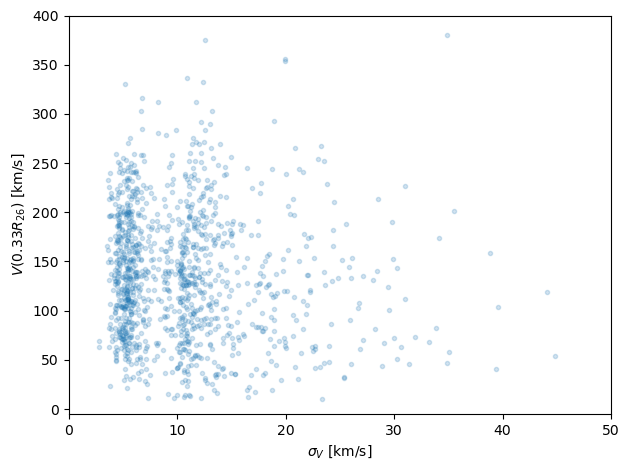

In [40]:
plt.figure(tight_layout=True)

plt.plot(SGA_TF_fuji['V_0p33R26_ERR'], SGA_TF_fuji['V_0p33R26'], '.', alpha=0.2)

plt.xlim(0,50)
plt.ylim(-5, 400)

plt.xlabel('$\sigma_V$ [km/s]')
plt.ylabel('$V(0.33R_{26})$ [km/s]');

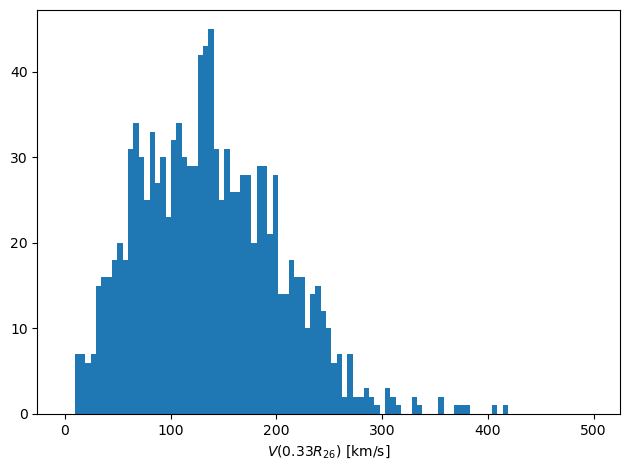

In [37]:
plt.figure(tight_layout=True)

plt.hist(SGA_TF_fuji['V_0p33R26'], bins=np.linspace(-1, 500, 100))

plt.xlabel('$V(0.33R_{26})$ [km/s]');

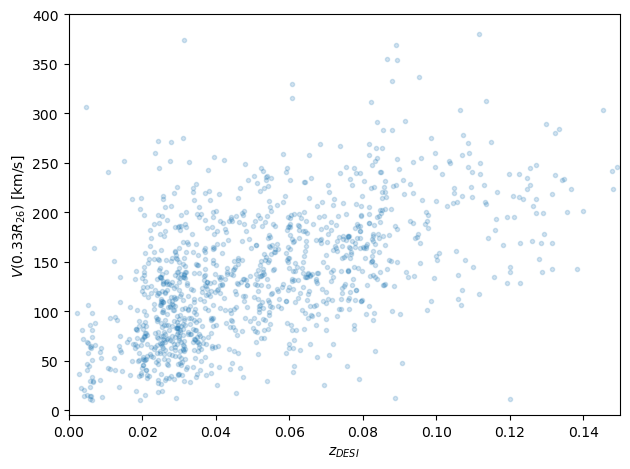

In [39]:
plt.figure(tight_layout=True)

plt.plot(SGA_TF_fuji['Z_DESI'], SGA_TF_fuji['V_0p33R26'], '.', alpha=0.2)

plt.xlim(0, 0.15)
plt.ylim(-5, 400)

plt.xlabel('$z_{DESI}$')
plt.ylabel('$V(0.33R_{26})$ [km/s]');

## Pull in `PHOTSYS` column

In [41]:
# photsys = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot_dVsys_photsys.fits')
photsys = Table.read('/Users/kdouglass/Documents/Research/data/DESI/SV/SGA-2020_fuji_Vrot_photsys.fits')

In [42]:
SGA_TF_fuji_photsys = join(SGA_TF_fuji, photsys['SGA_ID', 'PHOTSYS'], keys='SGA_ID')

## Write final catalog to file

In [43]:
# SGA_TF_fuji_photsys.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot_dVsys_photsys.fits', 
SGA_TF_fuji_photsys.write('SGA-2020_fuji_Vrot_VI_dVsys_photsys_corr.fits',
                          overwrite=True)